In [3]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#공용함수

In [ ]:
# 수정금지: 타임스탬프용 함수
from datetime import datetime
def printt(*args,**kwargs):
  now = datetime.now()
  now_str = "{:02}:{:02}:{:02}".format(now.hour,now.minute,now.second)
  print(now_str, *args,**kwargs)
  return int(now.hour)*60*60+int(now.minute)*60+int(now.second)

#연관 패키지 설치 (다른작업 금지)

In [45]:
#TODO: 해당 블럭에 패키지 설치하세요.
!pip install attrdict
!pip install transformers
!pip install seqeval
!pip install fastprogress
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 11.2 MB/s 


# 파일로딩 (다른작업 금지)

In [ ]:
#TODO: 해당 블럭에 필요 파일 로딩 코드 넣으시오.


# 모델 학습

In [ ]:
# 수정금지: 타임스탬프
_model_build_start_time = printt("Model building: Start")
_model_build_start_time

08:34:48 Model building: Start


30888

In [ ]:
#TODO: 블럭에 모델 학습 - 빌딩 코드를 넣으세요. (시간측정 구간)





In [5]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (43.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and di

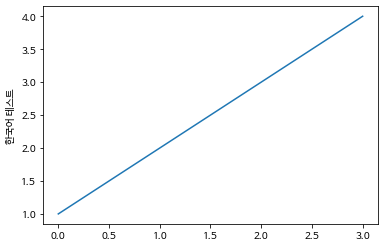

In [1]:
# 실행 전 런타임 다시시작
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
plt.plot([1, 2, 3, 4])
plt.ylabel('한국어 테스트')
plt.show()

In [15]:
# task = 'classification'
task = 'sentiment'
train_file = 'train_cls.txt'
test_file = 'evaluation_cls.txt'
full_text = 'full_text.txt'


# train_file = train_s_cls.txt
# test_file = test_s_cls.txt

In [16]:
# initialize logging
import logging

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

In [40]:
# make Input Example
class InputExample(object):
    """
    A single training/test example for simple sequence classification.
    """

    def __init__(self, guid, text_a, text_b, label):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"
        
# make Input Feature
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, attention_mask, token_type_ids, label):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

# make processor
class Processor(object):

    def __init__(self, args):
        self.args = args

    def get_labels(self):
        if self.args.task == 'classification':
        # return ['None', '상담원', '상담시스템', '고객서비스', '혜택', '할부금융상품', '커뮤니티서비스',
        #         '카드이용/결제', '카드상품', '청구입금', '심사/한도', '생활편의서비스', '상담/채널', '리스렌탈상품',
        #         '라이프서비스', '금융상품', '고객정보관리', '가맹점매출/승인', '가맹점대금', '가맹점계약', '삼성카드', '기타']
          return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
                  '13', '14', '15', '16']
        else:
          return ['0', '1']

    def _read_file(cls, input_file):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            lines = []
            for line in f:
                lines.append(line.strip())
            return lines

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines[0:]):
            line = line.split("\t")
            guid = "%s-%s" % (set_type, i)
            text_a = line[0]
            label = line[1]
            if i % 10000 == 0:
                logger.info(line)
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

    def get_examples(self, mode):
        """
        Args:
            mode: train, test
        """
        file_to_read = None
        if mode == "train":
            file_to_read = self.args.train_file
        elif mode == "test":
            file_to_read = self.args.test_file

        logger.info("LOOKING AT {}".format(os.path.join(self.args.data_dir, file_to_read)))
        return self._create_examples(
            self._read_file(os.path.join(self.args.data_dir, file_to_read)), mode
        )

In [49]:
# set config args for classification
from transformers import (
    ElectraConfig,
    ElectraTokenizer,
    ElectraForSequenceClassification,
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizer,
    XLMRobertaConfig
)
from attrdict import AttrDict
args = AttrDict(
    {
                 'data_dir': 'data/{}'.format(task),
                 'train_file': train_file,
                 'test_file': test_file,
                 'task': task,
                 'config': ElectraConfig,
                 'tokenizer': ElectraTokenizer,
                 'model': ElectraForSequenceClassification,
                #  'config': XLMRobertaConfig,
                #  'tokenizer': XLMRobertaTokenizer,
                #  'model': XLMRobertaForSequenceClassification,
                 'evaluate_test_during_training': True, 
                 'eval_all_checkpoints': True, 
                 'save_optimizer': False, 
                 'do_lower_case': False, 
                 'do_train': True, 
                 'do_eval': True, 
                 'max_seq_len': 128, 
                 'num_train_epochs': 10, 
                 'weight_decay': 0.0, 
                 'gradient_accumulation_steps': 1, 
                 'adam_epsilon': 1e-08, 
                 'warmup_proportion': 0, 
                 'max_steps': -1, 
                 'max_grad_norm': 1.0, 
                 'no_cuda': False, 
                 'model_type': 'koelectra-base-v3', 
                 'model_name_or_path': 'monologg/koelectra-base-v3-discriminator', 
                 'output_dir': '{}_checkpoints'.format(task), 
                 'seed': 42, 
                 'train_batch_size': 32, 
                 'eval_batch_size': 128, 
                 'logging_steps': 250, 
                 'save_steps': 250, 
                 'learning_rate': 5e-05
     }
)
if task == 'sentiment':
  args.logging_steps, args.save_steps = 249, 249

In [19]:
import torch

# set seed
torch.cuda.manual_seed_all(args.seed)

processor = Processor(args)
labels = processor.get_labels()


config = args.config.from_pretrained(
            args.model_name_or_path,
            num_labels=len(labels)
            # id2label={str(i): label for i, label in enumerate(labels)},
            # label2id={label: i for i, label in enumerate(labels)},
        )
tokenizer = args.tokenizer.from_pretrained(
    args.model_name_or_path,
    do_lower_case=args.do_lower_case
)
model = args.model.from_pretrained(
    args.model_name_or_path,
    config=config
)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [41]:
%cd /content/drive/MyDrive/Colab Notebooks
import os
from torch.utils.data import TensorDataset
logger = logging.getLogger(__name__)
print(__name__)
def load_and_cache_examples(args, tokenizer, mode):
    processor = Processor(args)
    output_mode = args.task
    # Load data features from cache or dataset file
    cached_features_file = os.path.join(
        args.data_dir,
        "cached_{}_{}_{}_{}".format(
            str(args.task), list(filter(None, args.model_name_or_path.split("/"))).pop(), str(args.max_seq_len), mode
        ),
    )
    if os.path.exists(cached_features_file):
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
    else:
        logger.info("Creating features from dataset file at %s", args.data_dir)
        if mode == "train":
            examples = processor.get_examples("train")
        elif mode == "test":
            examples = processor.get_examples("test")
        else:
            raise ValueError("For mode, choose between train and test")
        features = seq_cls_convert_examples_to_features(
            args, examples, tokenizer, max_length=args.max_seq_len
        )
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)



    if output_mode == "classification" or 'sentiment':
        all_labels = torch.tensor([f.label for f in features], dtype=torch.long)


    # if output_mode == "classification":
    #     all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    # elif output_mode == "regression":
    #     all_labels = torch.tensor([f.label for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
    return dataset
def seq_cls_convert_examples_to_features(args, examples, tokenizer, max_length):
    processor = Processor(args)
    label_list = processor.get_labels()
    output_mode = args.task
    logger.info("Using label list {}".format(label_list))
    logger.info("Using output mode {}".format(output_mode))

    # labels = [label_from_example(example) for example in examples]
    labels = [int(example.label) for example in examples]

    batch_encoding = tokenizer.batch_encode_plus(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        add_special_tokens=True,
        truncation=True,
    )

    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}
        if "token_type_ids" not in inputs:
            inputs["token_type_ids"] = [0] * len(inputs["input_ids"])  # For xlm-roberta

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

    for i, example in enumerate(examples[:5]):
        logger.info("*** Example ***")
        logger.info("guid: {}".format(example.guid))
        logger.info("input_ids: {}".format(" ".join([str(x) for x in features[i].input_ids])))
        logger.info("attention_mask: {}".format(" ".join([str(x) for x in features[i].attention_mask])))
        logger.info("token_type_ids: {}".format(" ".join([str(x) for x in features[i].token_type_ids])))
        logger.info("label: {}".format(features[i].label))

    return features
train_dataset = load_and_cache_examples(args, tokenizer, mode="train")
test_dataset = load_and_cache_examples(args, tokenizer, mode="test")


08/11/2021 12:03:28 - INFO - __main__ -   Loading features from cached file data/sentiment/cached_sentiment_koelectra-base-v3-discriminator_128_train


/content/drive/MyDrive/Colab Notebooks
__main__


08/11/2021 12:03:29 - INFO - __main__ -   Loading features from cached file data/sentiment/cached_sentiment_koelectra-base-v3-discriminator_128_test


In [42]:
import argparse
import json
import logging
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from transformers import (
    AdamW,
    get_linear_schedule_with_warmup
)
from tqdm.auto import tqdm


def train(args,
          model,
          train_dataset,
          test_dataset=None):
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)
    full_text = pd.read_csv(os.path.join(args.data_dir, 'full_text.txt'), sep='\t')
    # full_text = pd.read_csv('train_n_full.txt', sep='\t')
    print(full_text)
    if args.max_steps > 0:
        t_total = args.max_steps
        print()
        print(t_total, len(train_dataloader), args.gradient_accumulation_steps)
        print()
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
        print('max steps: ' + str(t_total), 'length of train data: ' + str(len(train_dataloader)),
              args.gradient_accumulation_steps)
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * args.warmup_proportion),
                                                num_training_steps=t_total)

    if os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt")) and os.path.isfile(
            os.path.join(args.model_name_or_path, "scheduler.pt")
    ):
        # Load optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Total train batch size = %d", args.train_batch_size)
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)
    logger.info("  Logging steps = %d", args.logging_steps)
    logger.info("  Save steps = %d", args.save_steps)

    global_step = 0
    tr_loss = 0.0

    model.zero_grad()
    mb = master_bar(range(int(args.num_train_epochs)))
    for epoch in tqdm(mb):
        epoch_iterator = progress_bar(train_dataloader, parent=mb)

        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "labels": batch[3]
            }

            if args.model_type not in ["distilkobert", "xlm-roberta"]:
                inputs["token_type_ids"] = batch[2]  # Distilkobert, XLM-Roberta don't use segment_ids
            outputs = model(**inputs)
            loss = outputs[0]

            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            loss.backward()
            tr_loss += loss.item()


            if (step + 1) % args.gradient_accumulation_steps == 0 or (
                    len(train_dataloader) <= args.gradient_accumulation_steps
                    and (step + 1) == len(train_dataloader)
            ):
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

                optimizer.step()
                scheduler.step()
                model.zero_grad()
                global_step += 1


                print("loss: " + str(tr_loss / global_step), end="\r")


                if args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    if args.evaluate_test_during_training:
                        evaluate(args, model, full_text, test_dataset, "test", global_step)

                if args.save_steps > 0 and global_step % args.save_steps == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "checkpoint-{}".format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )
                    model_to_save.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to {}".format(output_dir))

                    if args.save_optimizer:
                        torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                        torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                        logger.info("Saving optimizer and scheduler states to {}".format(output_dir))
            if args.max_steps > 0 and global_step > args.max_steps:
                break

        mb.write("Epoch {} done".format(epoch + 1))

        if args.max_steps > 0 and global_step > args.max_steps:
            break

    return global_step, tr_loss / global_step, full_text

In [47]:
def evaluate(args, model, full_text, eval_dataset, mode, global_step=None):
    results = {}
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    # Eval!
    if global_step != None:
        logger.info("***** Running evaluation on {} dataset ({} step) *****".format(mode, global_step))
    else:
        logger.info("***** Running evaluation on {} dataset *****".format(mode))
    logger.info("  Num examples = {}".format(len(eval_dataset)))
    logger.info("  Eval Batch size = {}".format(args.eval_batch_size))
    eval_loss = 0.0
    # nb_eval_steps = 0
    preds = None
    out_label_ids = None
    out_input_ids = None

    for batch in progress_bar(eval_dataloader):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "labels": batch[3]
            }

            if args.model_type not in ["distilkobert", "xlm-roberta"]:
                inputs["token_type_ids"] = batch[2]  # Distilkobert, XLM-Roberta don't use segment_ids
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        # nb_eval_steps += 1
        if preds is None:
            out_input_ids = inputs['input_ids'].detach().cpu().numpy()
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            out_input_ids = np.append(out_input_ids, inputs['input_ids'].detach().cpu().numpy(), axis=0)
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

        # 내가 수정한 부분

    tokenizer = args.tokenizer.from_pretrained(
        args.model_name_or_path,
        do_lower_case=args.do_lower_case
    )
    # label_dict = {'칭찬': 0, '중립': 0.5, '불만': 1}
    if args.task == 'classification':
      label_dict = {'중립': 0, '상담원': 1, '상담시스템': 2, '혜택': 3, '할부금융상품': 4,
                  '카드상품': 5, '청구입금': 6, '심사/한도': 7, '생활편의서비스': 8,
                  '상담/채널': 9, '리스렌탈상품': 10, '라이프서비스': 11, '금융상품': 12,
                  '고객정보관리': 13, '가맹점매출/승인': 14, '삼성카드': 15, '기타': 16}
    else:
      label_dict = {'칭찬': 0, '불만': 1}
    label_dict = dict((v, k) for k, v in label_dict.items())
    df_review = []
    # temp_review = []
    df_label = np.vectorize(label_dict.get)(out_label_ids)
    df_prediction = np.vectorize(label_dict.get(np.argmax(preds)))
    for i in range(len(out_input_ids)):
        review_list = list(out_input_ids[i])


        # temp_review.append(str(x) for x in out_input_ids[i])


        while 0 in review_list:
            review_list.remove(0)
        del review_list[0]
        del review_list[-1]
        df_review.append(tokenizer.decode(review_list))
        # print(review_list, label_dict[out_label_ids[i] - 1], label_dict[np.argmax(preds[i]) - 1])
    df_data = {'Review': df_review, 'Label': df_label, 'Prediction': df_prediction}
    df = pd.DataFrame(df_data)

    df_train_data = {'Review': full_text['Review'], 'Label': full_text['Label']}
    df_from_train = pd.DataFrame(df_train_data)
    # Dodged Bar Chart (with same X coordinates side by side)

    bar_width = 0.35
    alpha = 0.5
    label_lst = list(label_dict.values())
    index = np.arange(len(label_lst))
    count_list, cnt_pred, cnt_label = [0 for _ in range(len(label_dict))], \
                                    [0 for _ in range(len(label_dict))], [0 for _ in range(len(label_dict))]
    count_labels = df_from_train.groupby('Label', as_index=False).Review.count()
    acc_labels = df[df['Label'] == df['Prediction']].groupby('Label').Review.count()
    viable_label = list(count_labels['Label'])
    for i in range(len(viable_label)):
        count_list[viable_label[i]] = count_labels['Review'][i]
    for validation in range(len(out_label_ids)):
        if out_label_ids[validation] == np.argmax(preds, axis=1)[validation]:
            cnt_pred[out_label_ids[validation]] += 100
        cnt_label[out_label_ids[validation]] += 1
    for i in range(len(cnt_label)):
        if cnt_label[i] == 0:
            cnt_label[i] = 1
    acc_tot = np.divide(cnt_pred, cnt_label)
    acc_tot[np.isnan(acc_tot)] = 0
    # print(count_list)
    # print(acc_tot)
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.title('Bar Chart of Labels Count and Accuracy', fontsize=15)
    clrs = ['r' if (x < 15) else 'b' for x in count_list]
    p1 = plt.bar(index, count_list,
                 bar_width,
                 color=clrs,
                 alpha=alpha,
                 label='Count')
    plt.ylabel('Count of Labels', fontsize=12)
    plt.xticks([], [])
    # plt.legend((p1[0],), ('Count',), fontsize=10)
    plt.subplot(2, 1, 2)
    p2 = plt.bar(index + bar_width, acc_tot,
                 bar_width,
                 color=clrs,
                 alpha=alpha,
                 label='Accuracy')
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
    plt.ylabel('Accuracy by Labels', fontsize=12)
    plt.xlabel('Label', fontsize=12)
    plt.xticks(index, label_lst, fontsize=10, rotation=45)
    # plt.legend((p2[0],), ('Accuracy',), fontsize=10)
    plt.show()
        # for i in range(len(out_label_ids)):
        #     print(tokenizer.decode(out_ids[i]), out_label_ids[i], preds[i])
        # print(type(out_label_ids), type(preds))
        # print(out_label_ids, preds)
        #

    # eval_loss = eval_loss / nb_eval_steps
    # if output_modes[args.task] == "classification":
    preds_original = preds.copy()
    preds = np.argmax(preds, axis=1)
    # elif output_modes[args.task] == "regression":
    #     preds = np.squeeze(preds)
    result = compute_metrics(out_label_ids, preds)

    check_right = out_label_ids == preds
    df = pd.DataFrame(columns=['Review', 'Label', 'Prediction', 'Softmax'])
    for check_result in range(len(check_right)):
        if not check_right[check_result]:
            review_list = list(out_input_ids[check_result])
            while 0 in review_list:
                review_list.remove(0)
            del review_list[0]
            del review_list[-1]
            df = df.append({'Review': tokenizer.decode(review_list), 
                           'Label': label_dict[out_label_ids[check_result]], 
                           'Prediction': label_dict[preds[check_result]],
                           'Softmax': preds_original[check_result]},
                           ignore_index=True
                           )
    
    print(df.head())
    df.to_csv(r'analysis_ckpt_{}_{}.csv'.format(args.task, global_step), header=None, index=None, sep='\t', mode='a')
            # print(tokenizer.decode(review_list), 'Label: ' + str(label_dict[out_label_ids[check_result]]) + ' Prediction: ' + str(
            #     label_dict[preds[check_result]]))


    # numpy_data = np.array(out_label_ids, preds)
    # df = pd.DataFrame(data=numpy_data, index=["row1", "row2"], columns=["column1", "column2"])
    print(result)
    results.update(result)
    output_dir = os.path.join(args.output_dir, mode)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_eval_file = os.path.join(output_dir,
                                    "{}-{}.txt".format(mode, global_step) if global_step else "{}.txt".format(mode))
    with open(output_eval_file, "w") as f_w:
        logger.info("***** Eval results on {} dataset *****".format(mode))
        for key in sorted(results.keys()):
            logger.info("  {} = {}".format(key, str(results[key])))
            f_w.write("  {} = {}\n".format(key, str(results[key])))

    return results

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return {"acc": (labels == preds).mean()}

08/11/2021 12:28:52 - INFO - __main__ -   ***** Running training *****
08/11/2021 12:28:52 - INFO - __main__ -     Num examples = 7943
08/11/2021 12:28:52 - INFO - __main__ -     Num Epochs = 10
08/11/2021 12:28:52 - INFO - __main__ -     Total train batch size = 32
08/11/2021 12:28:52 - INFO - __main__ -     Gradient Accumulation steps = 1
08/11/2021 12:28:52 - INFO - __main__ -     Total optimization steps = 2490
08/11/2021 12:28:52 - INFO - __main__ -     Logging steps = 249
08/11/2021 12:28:52 - INFO - __main__ -     Save steps = 249


                                                 Review  Label
0                    스마트 앱으로  자동 넘어가는 것 불편함  문자 이용하려 해도      1
1     상담 시에 고객의 의문사항을 충분히 들어 주었으면 함  상담사 말소리가 너무 빨라서...      1
2                                     카톡 상담이 가능했으면 좋겠어요      1
3     연회비가 있다는 것에 아쉬움이 있습니다 카드 사용의 활성화를 위해 어느 정도 사용 ...      1
4                                       이해를 못 하시는 거 같아요      1
...                                                 ...    ...
9925                                  무이자계월수을좀더길게주면좋겠어요      1
9926                                        너무 친절해요 좋아요      0
9927       Ars가 너무 이상하다  관리자가 직접 한번 눌려보시길 바란다   정말 최악이다      1
9928                  무이자로 구매할 수 있는 명확한 기준을 알려주시면 좋겠습니다      1
9929                          상담원 연결 시  기다리는 시간이  오래 걸림      1

[9930 rows x 2 columns]
max steps: 2490 length of train data: 249 1


08/11/2021 12:34:14 - INFO - __main__ -   ***** Running evaluation on test dataset (249 step) *****
08/11/2021 12:34:14 - INFO - __main__ -     Num examples = 1987
08/11/2021 12:34:14 - INFO - __main__ -     Eval Batch size = 128


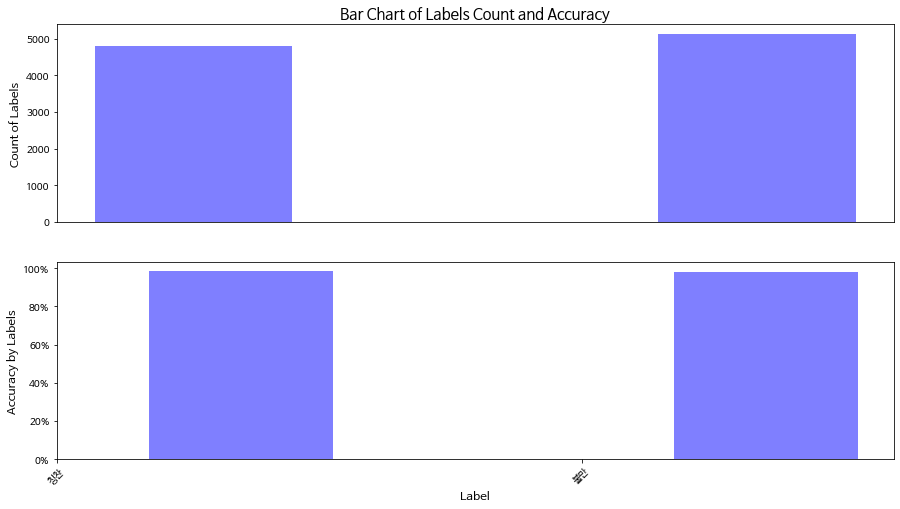

08/11/2021 12:34:47 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 12:34:47 - INFO - __main__ -     acc = 0.9828887770508304


                                              Review  ...                  Softmax
0  항상 수고가 많으십니다 궁금한 사항이 있습니다 제가 삼성카드에 긴급재난은 신청할 때...  ...  [0.2620223, -0.2600494]
1                 상담원과 직접 통화 시 대기시간 없이 바로 [UNK] 좋습니다  ...  [-2.9465706, 2.3269236]
2  바로 위에 같은 내용인데 디지털로 넘어가기 전 선택할 수 있도록 창이 뜨는 게 좋은...  ...  [1.8641884, -1.7275277]
3  상담한 직원분이 끝까지 책임지고 해결해 주시는 부분은 다 카드사에서는 보기 힘든데 ...  ...   [-4.494623, 3.4940238]
4                       전화 걸면 상담원이 빨리 나오는 게 너무너무 좋아요  ...   [-4.170343, 3.2794163]

[5 rows x 4 columns]
{'acc': 0.9828887770508304}


08/11/2021 12:34:49 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-249


08/11/2021 12:40:11 - INFO - __main__ -   ***** Running evaluation on test dataset (498 step) *****
08/11/2021 12:40:11 - INFO - __main__ -     Num examples = 1987
08/11/2021 12:40:11 - INFO - __main__ -     Eval Batch size = 128


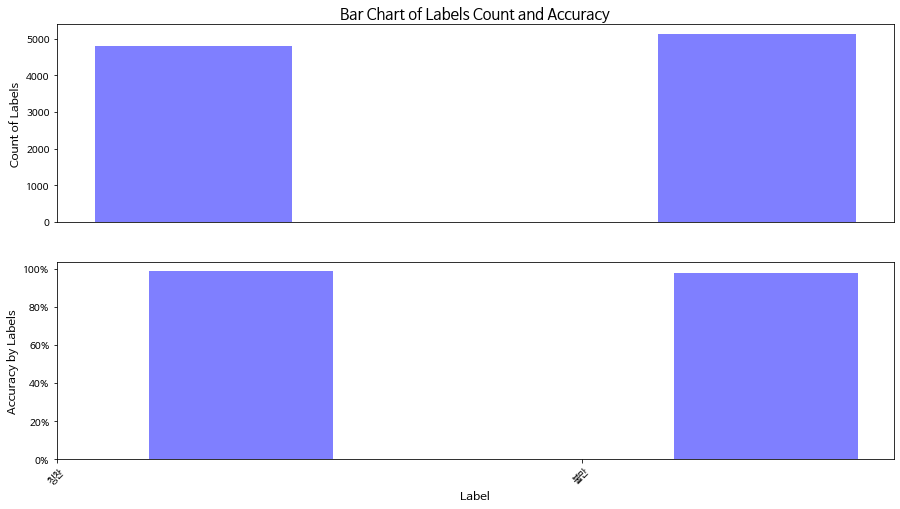

08/11/2021 12:40:44 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 12:40:44 - INFO - __main__ -     acc = 0.984398590840463


                                              Review  ...                  Softmax
0  항상 수고가 많으십니다 궁금한 사항이 있습니다 제가 삼성카드에 긴급재난은 신청할 때...  ...  [4.4295974, -4.3122387]
1     이메일 상담을 한지 3일이 지났는데도 회신이 없어서 전화 상담으로 완료 해결했습니다  ...  [3.7470133, -3.6323469]
2                                          신속 정확해주세요  ...  [4.6521044, -4.5470676]
3  상담한 직원분이 끝까지 책임지고 해결해 주시는 부분은 다 카드사에서는 보기 힘든데 ...  ...    [-5.400919, 4.207979]
4                      삼성카드엔 연회비가 없는 카드가 없는 게 타사와 다름  ...   [4.4733024, -4.344222]

[5 rows x 4 columns]
{'acc': 0.984398590840463}


08/11/2021 12:40:46 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-498


08/11/2021 12:46:07 - INFO - __main__ -   ***** Running evaluation on test dataset (747 step) *****
08/11/2021 12:46:07 - INFO - __main__ -     Num examples = 1987
08/11/2021 12:46:07 - INFO - __main__ -     Eval Batch size = 128


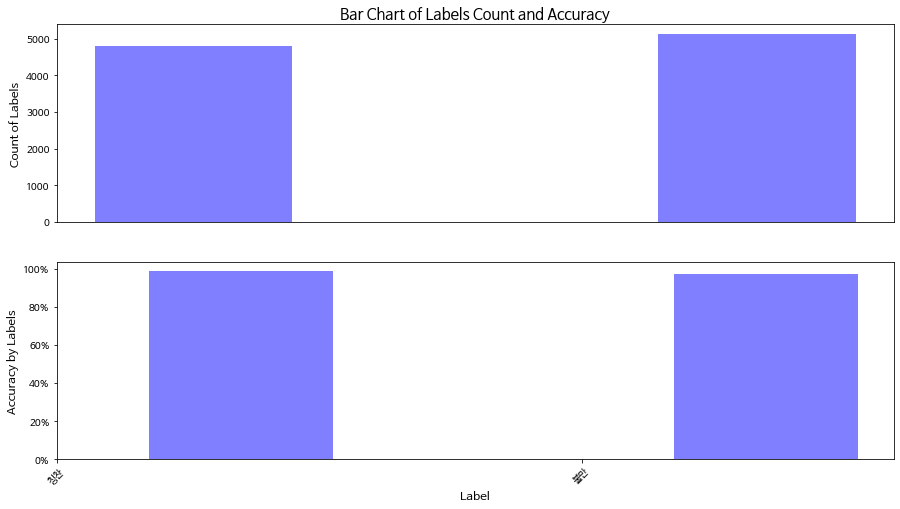

08/11/2021 12:46:41 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 12:46:41 - INFO - __main__ -     acc = 0.9818822345244087


                                              Review  ...                  Softmax
0     상담 내용 결과가 몇 시간 후에 적용된다고 하는 점 소비자 즉시 될 것으로 생각한데  ...  [1.6574174, -1.4906276]
1     이메일 상담을 한지 3일이 지났는데도 회신이 없어서 전화 상담으로 완료 해결했습니다  ...   [2.4959972, -2.327582]
2                                          신속 정확해주세요  ...  [3.7226713, -3.5955222]
3  바로 위에 같은 내용인데 디지털로 넘어가기 전 선택할 수 있도록 창이 뜨는 게 좋은...  ...  [3.0476499, -2.8793232]
4  상담한 직원분이 끝까지 책임지고 해결해 주시는 부분은 다 카드사에서는 보기 힘든데 ...  ...  [-5.0564036, 3.9790688]

[5 rows x 4 columns]
{'acc': 0.9818822345244087}


08/11/2021 12:46:43 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-747


08/11/2021 12:52:04 - INFO - __main__ -   ***** Running evaluation on test dataset (996 step) *****
08/11/2021 12:52:04 - INFO - __main__ -     Num examples = 1987
08/11/2021 12:52:04 - INFO - __main__ -     Eval Batch size = 128


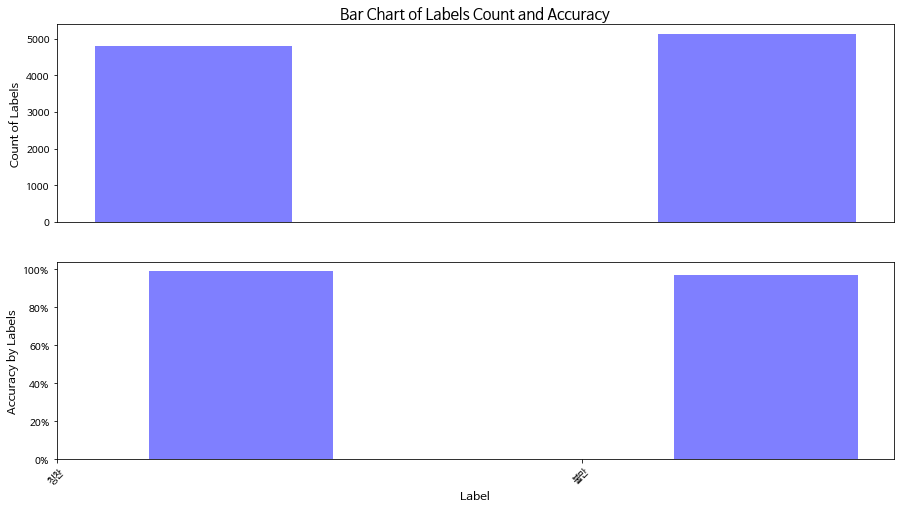

08/11/2021 12:52:38 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 12:52:38 - INFO - __main__ -     acc = 0.980372420734776


                                              Review  ...                   Softmax
0  항상 수고가 많으십니다 궁금한 사항이 있습니다 제가 삼성카드에 긴급재난은 신청할 때...  ...   [3.8005757, -3.6577632]
1                               뭐라는지 이해가 안됨 그냥 알았다 함  ...    [1.280426, -1.1276094]
2                                       삼성카드가 제일 나아요  ...      [-4.88557, 3.836867]
3     이메일 상담을 한지 3일이 지났는데도 회신이 없어서 전화 상담으로 완료 해결했습니다  ...  [0.96950823, -0.8693323]
4         고객 상황에 대한 파악이 안됨 타사에서는 답변이 되나 삼성에서는 답변이 안됨  ...   [1.8670479, -1.6977682]

[5 rows x 4 columns]
{'acc': 0.980372420734776}


08/11/2021 12:52:40 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-996


08/11/2021 12:58:01 - INFO - __main__ -   ***** Running evaluation on test dataset (1245 step) *****
08/11/2021 12:58:01 - INFO - __main__ -     Num examples = 1987
08/11/2021 12:58:01 - INFO - __main__ -     Eval Batch size = 128


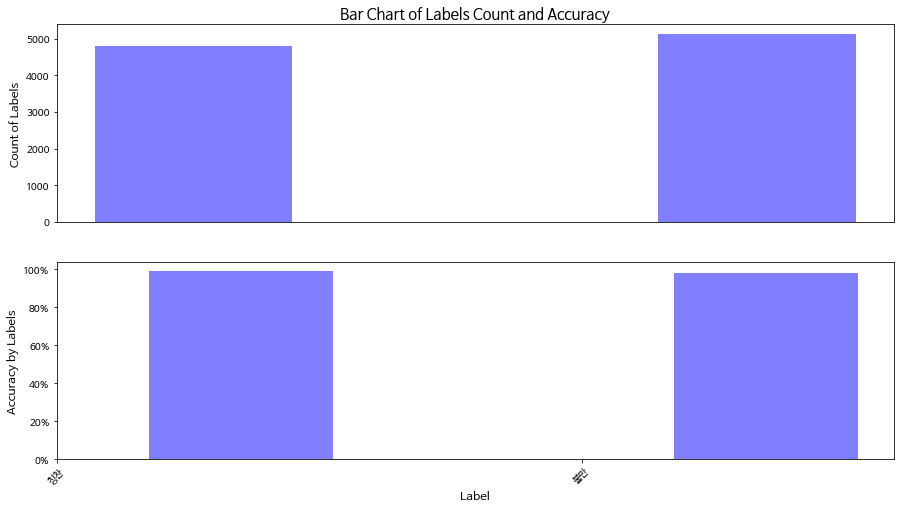

08/11/2021 12:58:35 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 12:58:35 - INFO - __main__ -     acc = 0.984398590840463


                                              Review  ...                    Softmax
0  화면 선택으로 바뀌기 전에는 전화연결이 훨씬 쉬웠습니다 상담원 연결은 기다리지 않게...  ...     [1.284013, -1.1374961]
1     이메일 상담을 한지 3일이 지났는데도 회신이 없어서 전화 상담으로 완료 해결했습니다  ...  [0.28819865, -0.22526142]
2                                          신속 정확해주세요  ...    [2.7248268, -2.5980904]
3                                               불친절함  ...   [0.9230222, -0.81562424]
4  바로 위에 같은 내용인데 디지털로 넘어가기 전 선택할 수 있도록 창이 뜨는 게 좋은...  ...    [2.5401464, -2.3877656]

[5 rows x 4 columns]
{'acc': 0.984398590840463}


08/11/2021 12:58:37 - INFO - __main__ -   Saving model checkpoint to sentiment_checkpoints/checkpoint-1245


In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from fastprogress.fastprogress import master_bar, progress_bar

# GPU or CPU
args.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
model.to(args.device)

# Train
global_step, tr_loss, full_text = train(args, model, train_dataset, test_dataset)
logger.info(" global_step = {}, average loss = {}".format(global_step, tr_loss))

08/11/2021 10:20:10 - INFO - __main__ -   Evaluate the following checkpoints: ['koelectra-base-v3-nsmc-ckpt/checkpoint-1', 'koelectra-base-v3-nsmc-ckpt/checkpoint-10', 'koelectra-base-v3-nsmc-ckpt/checkpoint-1000', 'koelectra-base-v3-nsmc-ckpt/checkpoint-11', 'koelectra-base-v3-nsmc-ckpt/checkpoint-1250', 'koelectra-base-v3-nsmc-ckpt/checkpoint-1500', 'koelectra-base-v3-nsmc-ckpt/checkpoint-1750', 'koelectra-base-v3-nsmc-ckpt/checkpoint-2', 'koelectra-base-v3-nsmc-ckpt/checkpoint-2000', 'koelectra-base-v3-nsmc-ckpt/checkpoint-2250', 'koelectra-base-v3-nsmc-ckpt/checkpoint-250', 'koelectra-base-v3-nsmc-ckpt/checkpoint-2500', 'koelectra-base-v3-nsmc-ckpt/checkpoint-3', 'koelectra-base-v3-nsmc-ckpt/checkpoint-4', 'koelectra-base-v3-nsmc-ckpt/checkpoint-5', 'koelectra-base-v3-nsmc-ckpt/checkpoint-500', 'koelectra-base-v3-nsmc-ckpt/checkpoint-6', 'koelectra-base-v3-nsmc-ckpt/checkpoint-7', 'koelectra-base-v3-nsmc-ckpt/checkpoint-750', 'koelectra-base-v3-nsmc-ckpt/checkpoint-8', 'koelectra-b

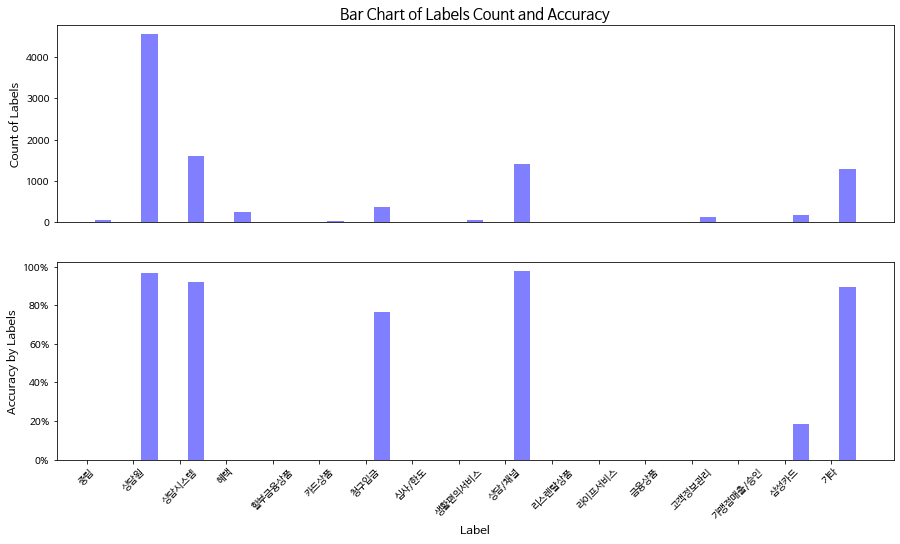

08/11/2021 10:20:35 - INFO - __main__ -   ***** Eval results on test dataset *****
08/11/2021 10:20:35 - INFO - __main__ -     acc = 0.8701947079380928


                                              Review  Label Prediction
0  삼성카드 택배 배달 시 사전 전화 약속하고 카드 배달하세요 기본 아닙니까 집에서 작...   카드상품        상담원
1  홈페이지를 이용할 경우 오류가 잦아 매우 불편함 전화 문의는 대기 시간이 오래 걸려...  상담시스템      상담/채널
2  상담원과의 통화대기시간안내가 현실적으로 차이가 있을 때입니다 대기시간이 1시간 정도...  상담시스템      상담/채널
3                                 상담원 연결까지 너무 오랴 걸려요  상담시스템      상담/채널
4                4번과 5번은 크게 의미 없는데 다음단게로 넘어가기 위한 클릭임    상담원      상담/채널
{'acc': 0.8701947079380928}


KeyboardInterrupt: ignored

In [ ]:
results = {}
checkpoints = list(
            os.path.dirname(c) for c in
            sorted(glob.glob(args.output_dir + "/**/" + "pytorch_model.bin", recursive=True))
        )
if not args.eval_all_checkpoints:
    checkpoints = checkpoints[-1:]
else:
    logging.getLogger("transformers.configuration_utils").setLevel(logging.WARN)  # Reduce logging
    logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
logger.info("Evaluate the following checkpoints: %s", checkpoints)
for checkpoint in checkpoints:
    global_step = checkpoint.split("-")[-1]
    model = args.model.from_pretrained(checkpoint)
    model.to(args.device)
    result = evaluate(args, model, full_text, test_dataset, mode="test", global_step=global_step)
    result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
    results.update(result)

output_eval_file = os.path.join(args.output_dir, "eval_results.txt")
with open(output_eval_file, "w") as f_w:
    for key in sorted(results.keys()):
        f_w.write("{} = {}\n".format(key, str(results[key])))

In [ ]:
# 수정금지: 타임스탬프
_model_build_end_time = printt("Model building: Start")
print(_model_build_end_time - _model_build_start_time)

NameError: ignored

#모델 분류

In [ ]:
# 수정금지: 타임스탬프
_test_start_time = printt("TEST: Start")

In [ ]:
#TODO: 해당 블럭에 테스트 수행을 위한 코드를 넣으세요. (시간측정 구간)
#분석 파일은 tsv 파일로 제공되며, 제공되는 학습데이터 파일과 동일한 레이아웃(단, 정답 분류 =공백)으로 제공됩니다.




In [ ]:
# 수정금지: 타임스탬프
_test_end_time = printt("Model building: Start")
print(_test_end_time - _test_start_time)

# 결과출력

In [ ]:
#TODO:해당 블럭에 테스트 결과를 파일로 저장하는 코드를 넣으세요. (시간측정 제외)
#저장 파일은tsv 파일로 제공되는 학습데이터 파일과 동일한 레이아웃(단, 정답 분류 = 테스트 결과 도출된 양식)으로 저장


